# Transfer Learning for NLP in Keras

This notebook is my school week4 homework at "Introduction to Deep Learning" class by CU boulder on coursera.

## Abstraction

This notebook's goal is to detect whether tweet is about a real disaster or not. The predictions neeed to be 0 or 1 based on text data, so this is binary classification task. Our solution for this task is to utilize transfer learning, using `universal sentence encoder`. On top of the embedding layers, we apply `GRU` RNN layers and Dense layers for classifier. The metric for this original competition is `F-1` score, but we also evaluate our training model with precision and recall as well. Our model would be improved by cross-validate training. We carefully prepare training/validation set so that duplicate data don't exist on both set at the same time. That could prevent data leakage issue when training the model. The challenge for NLP task is that language data is more nuance and ambiguous. Using deep learning with pretrained data(transfer learning) is appropriate, rather than building model from scratch.

Here is our notebook workflow:

1. Load necessary libraries
2. Get the training/test dataset
3. EDA
4. Feature extraction
5. Load universal sentence encoder
6. Build and evaluate model
7. Hyper parameter tuning
8. Make prediction for submitting it to competition
9. Discussion/conclusion

The original competition is hosted in kaggle, https://www.kaggle.com/competitions/nlp-getting-started/overview. You can install the same dataset as we use in this notebook at the competition page.


**keywords**: binary classification, f1-score, Keras, transfer learning, universal-sentence-encoder, cross-validation

## Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


import tensorflow as tf
print(tf.__version__)
import tensorflow_hub as hub
import keras_tuner as kt
import tensorflow_text as tf_text


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import requests
from pathlib import Path

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy) 
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

2.11.0
Compute dtype: float16
Variable dtype: float32


In [2]:
path = Path("/kaggle/input/nlp-getting-started")
!ls {path}

sample_submission.csv  test.csv  train.csv


## Load dataset

The training dataset's entries are `7613`, while testset are `3263`. That was not a big data so we might not need to subsample dataset when training the model.

In [3]:
df_train = pd.read_csv(path/"train.csv", low_memory=True)
df_test = pd.read_csv(path/"test.csv", low_memory=True)
print("Training set shape: ", df_train.shape)
print("Test set shape: ", df_test.shape)

Training set shape:  (7613, 5)
Test set shape:  (3263, 4)


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## EDA

The missiong value are found at 2 columns, keyword and location. We should replace that NaN value with something at feature extraction part. Target and Id are all uniqule, while other columns contain some duplicate value.

In [5]:
print(df_train.info())
df_train.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


The keyword and location has missing value, especially one-third locaiton are NaN. That could worse model's performance if we include this column to the model's predictors.

In [6]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Traget class is a bit imbalanced based on pi-chart below. Disaster tweeds, 1 value, is a bit less relatively. Some data augumentation might be help for that inequality.

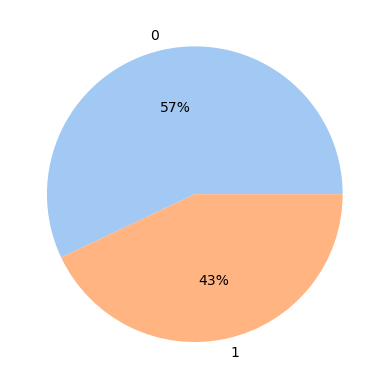

In [7]:
df_train.target.value_counts()

colors = sns.color_palette('pastel')[0:5]
plt.pie(df_train.target.value_counts(), labels=[0, 1], colors = colors, autopct='%.0f%%')
plt.show()

One  interesting findings are training and test dataset contains some common dataset. For instance, The most frequet text data, `11-Year-Old Boy` exits in both set. This is kinda data leakage but we keep using that as is. This duplication could worse the model's generalization if real test data is different from our training set.

In [8]:
df_train.text.value_counts()[:70]

11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...        10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                      6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                               6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_     6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                  5
                                                                                                                                                ..
#TweetLikeItsSeptember11th2001 Those two buildings are on fire                                                        

In [9]:
df_test.text.value_counts()[:20]

11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...         3
@PumpkinMari_Bot lemme just derail this real quivk to say. HELL DAMN F                                                                           2
Bushfire causes first victim in Albania ::  The multiple fires in Albania have caused the first vict http://t.co/yuba6XmBlq #Bush                2
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM                                                                                     2
To fight bioterrorism sir.                                                                                                                       2
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives: A group of villagers saved over 70 passengers' lives after two train...         2
.@denisleary Not sure how these folks rush into burning buildings but I'm grateful they do. #TrueHeroes               

## Feature engineering

We combine keyword and text into one `input` column. We exclude location data since it mostly worsen our model's performance. Below codes ilustrates how data is tokenized before feeding them to the sentence encoder. According to discussion forumn, the universal encoder uses `tf_text.SentencepieceTokenizer` for preprocessing text data. The code shows the data is converted by that tokenizer.

In [10]:
url = "https://github.com/tensorflow/text/blob/master/tensorflow_text/python/ops/test_data/test_oss_model.model?raw=true"
sp_model = requests.get(url).content
tokenizer = tf_text.SentencepieceTokenizer(sp_model, out_type=tf.string)

df_train[['keyword', 'location']] = df_train[['keyword', 'location']].fillna('')
df_train["input"] = df_train.text  + " " + df_train.keyword
df_train["input"] = df_train["input"].str.lower()
df_test[['keyword', 'location']] = df_test[['keyword', 'location']].fillna('')
df_test["input"] = df_test.text  + " " + df_test.keyword
df_test["input"] = df_test["input"].str.lower()

print(df_train[100:101].keyword)
print(tokenizer.tokenize(df_train[99:100].input))

100    accident
Name: keyword, dtype: object
<tf.RaggedTensor [[b'\xe2\x96\x81only', b'\xe2\x96\x81had', b'\xe2\x96\x81a',
  b'\xe2\x96\x81c', b'ar', b'\xe2\x96\x81for', b'\xe2\x96\x81not',
  b'\xe2\x96\x81even', b'\xe2\x96\x81a', b'\xe2\x96\x81week',
  b'\xe2\x96\x81and', b'\xe2\x96\x81got', b'\xe2\x96\x81in',
  b'\xe2\x96\x81a', b'\xe2\x96\x81f', b'u', b'c', b'k', b'ing',
  b'\xe2\x96\x81c', b'ar', b'\xe2\x96\x81a', b'c', b'c', b'id', b'ent',
  b'\xe2\x96\x81', b'.', b'.', b'\xe2\x96\x81', b'm', b'f', b's',
  b'\xe2\x96\x81can', b"'", b't', b'\xe2\x96\x81f', b'u', b'c', b'k',
  b'ing', b'\xe2\x96\x81dr', b'ive', b'\xe2\x96\x81', b'.',
  b'\xe2\x96\x81a', b'c', b'c', b'id', b'ent']]>


Based on EDA result, we decided to separate our training dataset in a way, that no duplicates text data exist in both set at the same time. For instance, if `11-year-old boy charged` text exists in training set, it doesn't in validation set, and vice versa. What if we just randomly seprate our model into training/validation set. This will cause the data leakage since both set could have same data. That's why we should separete our data in a no duplication way. The thing we don't do is relabelling our target value. Some duplicated text data are not consistent labelled, but we leave it as is. It's because most of duplicate data is labelled correctly and model could learn those majority thanks to our separated method while training.

In [11]:
def train_test_nodupl_split(df_train, feat_col="text", val_prop=0.2, random_state=42):
    feat_uniq = df_train[feat_col].unique()
    feat_uniq_n = len(feat_uniq)
    np.random.seed(random_state)
    np.random.shuffle(feat_uniq)

    val_feat = feat_uniq[:int(len(feat_uniq) * val_prop)]
    is_val = np.isin(df_train[feat_col], val_feat)
    idxs = np.arange(len(df_train))
    val_idxs = idxs[is_val]
    train_idxs = idxs[~is_val]
    
    train = df_train.iloc[train_idxs]
    valid = df_train.iloc[val_idxs]
    return train[feat_col], valid[feat_col], train.target, valid.target
    
X_train, X_val, y_train, y_val = train_test_nodupl_split(df_train, "input", random_state=42)
print("\ntrain")
print(X_train.value_counts())
print("\nvalid")
print(X_val.value_counts())



train
11-year-old boy charged with manslaughter of toddler: report: an 11-year-old boy has been charged with manslaughter over the fatal sh... fatal                 10
he came to a land which was engulfed in tribal war and turned it into a land of peace i.e. madinah. #prophetmuhammad #islam engulfed                            6
#bestnaijamade: 16yr old pkk suicide bomber who detonated bomb in ... http://t.co/ksawlyux02 bestnaijamade bestnaijamade bestnaijamade beû_ suicide%20bomb     6
madhya pradesh train derailment: village youth saved many lives derailment                                                                                      5
that horrible sinking feeling when youûªve been at home on your phone for a while and you realise its been on 3g this whole time sinking                       5
                                                                                                                                                               ..
@petchary but i can't

## Load universal sentence encoder

When we feed text data into DL model. we need to find a way to convert it to numerial value beforehand, but how? The pretrained model could be help!

The universal sentene encoder encodes text into high dimensional vectors. We will use this vectrozed text as feature extraction embedding layers in our model. The encoder is already traind with fine tuning, so we leave it untrainable. One cool feature for this encoder is we don't need to preprocess textdata before feeding them since it is already included in the encoders. According to official docs, it says no preprocessing but we apply some little to the data beforehand, like `df_train["input"].str.lower()`. Its because it improved a bit performance so some other preprocessing could also help even if not neccesary.

In [12]:
base_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
encoder = hub.KerasLayer(base_url, trainable=False)

Here is helper functions and hyper parameter, We use them in the model building and evaluation section.

In [13]:
epochs = 15
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=1, min_lr=0.0001),
            ]


def get_model(encoder):
    inputs = tf.keras.Input(shape=[], dtype=tf.string)
    x = encoder(inputs)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Reshape((1, -1))(x)
    x = tf.keras.layers.GRU(100, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)(x)
    x = tf.keras.layers.GRU(100, dropout=0.4, recurrent_dropout=0.4)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(1)(x)
    outputs = tf.keras.layers.Activation("sigmoid", dtype="float32")(x)
    
    return tf.keras.Model(inputs, outputs)


def fit_model(X_train, y_train, X_val, y_val, epochs=10, callbacks=[], verbose=0):
    return model.fit(X_train, y_train, 
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    use_multiprocessing=True,
                    workers=4,
                    callbacks=callbacks,
                    verbose=verbose,)

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history["accuracy"], label="Train Accuracy")
    axes[0].plot(history.history["val_accuracy"], label="Validation Accuracy")
    axes[0].set_title("Train/Valid Accuracy")
    axes[0].legend()

    axes[1].plot(history.history["loss"], label="Train Loss")
    axes[1].plot(history.history["val_loss"], label="Validation Loss")
    axes[1].set_title("Train/Valid Loss")
    axes[1].legend()

    plt.show()
    
def get_report(y_pred, y_val):
    # y_pred = model.predict(X_val, verbose=1)
    print(classification_report(y_val, (y_pred > 0.5).astype(int)[:, 0]))

## Build and Evaluate model

We build binary text classifier model, on top of tf-hub module that can embed sentence. The embed sentence are processed by universal sentence encoder. 

The dataflows are like this. Each layers contains some regulirization techniques, like dropout and batchnormalizatoin:

1. Feed text data without preprocessing
2. Embed sentence by pretrained model, universal sentence encoder
3. Go through 2 GRU RNN layers
4. Go through 2 FCC Dense layers
5. Output sigmoid activated value

One key point is our model's trainable parameters. We set `encoder.trainable = False` so encoder are freezed, while later layers like GRU and Dense will update weights while training.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 reshape (Reshape)           (None, 1, 512)            0         
                                                                 
 gru (GRU)                   (None, 1, 100)            184200    
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense (Dense)               (None, 128)               12928 

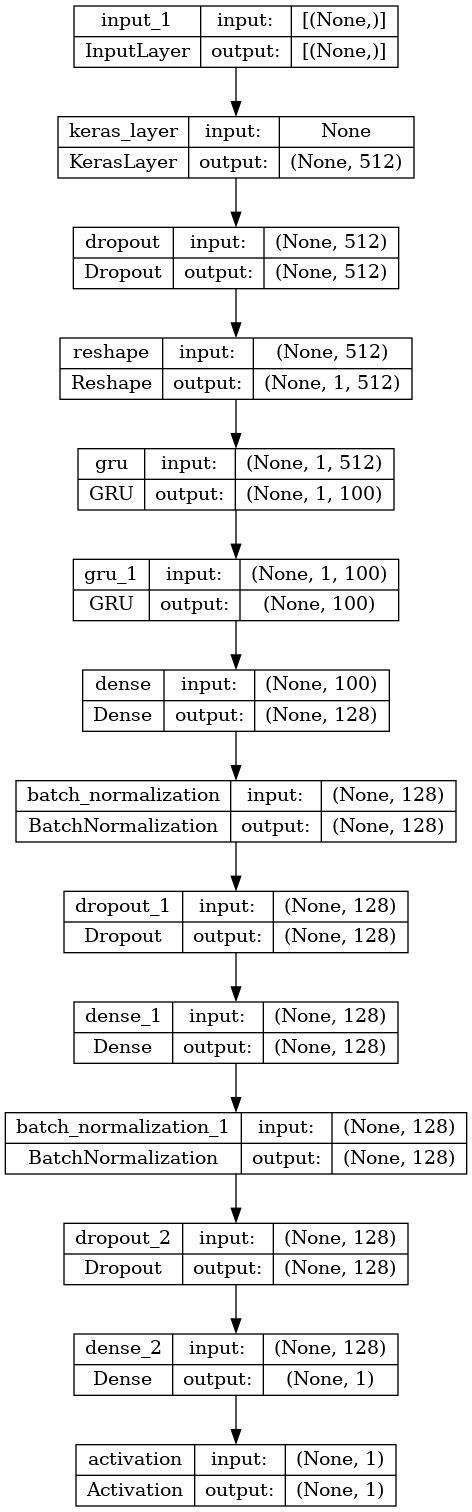

In [14]:
model = get_model(encoder)
model.summary()
optimizer = tf.keras.optimizers.experimental.AdamW()
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
tf.keras.utils.plot_model(model, show_shapes=True)

When we fit our model, it gets `0.78` accuracy on training and `0.79` on validation set after 10 epochs. The accuracy and loss plots indicate the model hit to some convergence without overfitting. We also experiment our RNN layers, like bidirectional LSTM, but GRU results in better performance.

Below the plot, the log shows classification matrix. The competition requires us to evaluate the model in `f-1` score, we plot it. No disaster tweets are a bit better performane, while distaster tweets are bit worsen. It might be because of target's imbalanceing.

        loss  accuracy  val_loss  val_accuracy       lr
1   0.688793  0.662676  0.665790      0.564356  0.00100
2   0.543468  0.744506  0.564345      0.743894  0.00100
3   0.529175  0.757625  0.495042      0.783498  0.00100
4   0.499759  0.767793  0.470535      0.789439  0.00100
5   0.491867  0.774352  0.463329      0.782838  0.00100
6   0.481381  0.779272  0.462813      0.785479  0.00100
7   0.479349  0.774680  0.458427      0.791419  0.00100
8   0.482146  0.782388  0.461502      0.786799  0.00100
9   0.477144  0.781404  0.462025      0.790099  0.00090
10  0.467872  0.785667  0.461937      0.789439  0.00081


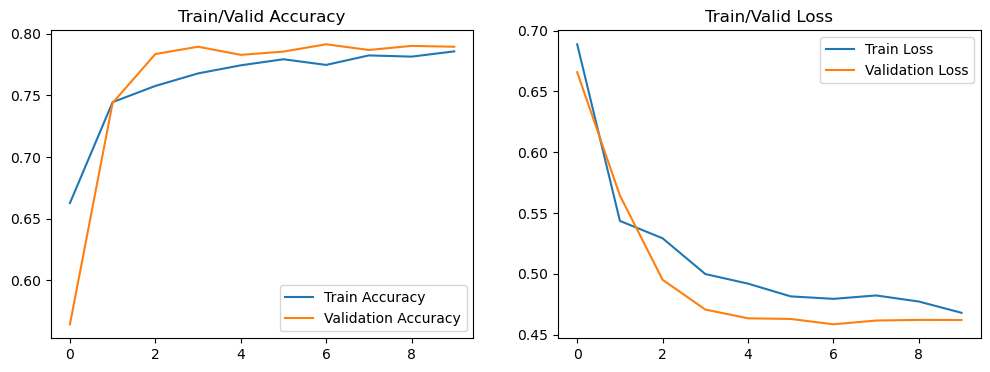

48/48 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       855
           1       0.85      0.63      0.72       660

    accuracy                           0.79      1515
   macro avg       0.81      0.77      0.78      1515
weighted avg       0.80      0.79      0.78      1515



In [15]:
history = fit_model(X_train, y_train, X_val, y_val, epochs, callbacks)
history_df = pd.DataFrame(history.history)
history_df.index += 1
print(history_df)
plot_history(history)
get_report(model.predict(X_val, verbose=1), y_val)

## Hyper parameter tuning

We use `keras_tuner` for tuning hyper parameters. We update params based on the results.

Note: the below codes taks a lot of time and memory, it could be run out of memory. We should comment them out before submitting the notebook to kaggle.

In [17]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = get_model(encoder)
        lr = hp.Float('learning_rate', min_value = 1e-5, max_value =1e-1, sampling='log')
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, ),
                     loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.04),
                     metrics=["accuracy"],)

        return model

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=10
)

tuner.search(X_train, y_train,
             validation_data= (X_val,y_val),
             epochs=epochs,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

best_hps= tuner.get_best_hyperparameters(1)[0]

In [27]:
# Update hyper params
base_lr = 0.001
optimizer = tf.keras.optimizers.experimental.AdamW(learning_rate=base_lr, amsgrad=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=4),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=1, min_lr=base_lr/10),
            ]
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.04)

After updating hyper parameter, we get improved score, especially f1 score to disater tweets. The improvement is from `0.72` to `0.8`. That was awesome. One concern is out model doesn't get to the convergence based on the plot history. Thus, we decided to apply cross-validation for more generalized results.

       loss  accuracy  val_loss  val_accuracy        lr
1  0.718228  0.647145  0.637571      0.558110  0.001000
2  0.576364  0.727672  0.538020      0.812261  0.001000
3  0.551727  0.750805  0.449133      0.823755  0.001000
4  0.528365  0.762372  0.443395      0.818646  0.001000
5  0.524844  0.768082  0.431064      0.830140  0.001000
6  0.506279  0.777892  0.431706      0.830140  0.001000
7  0.513327  0.767643  0.445165      0.830140  0.000900
8  0.506355  0.776281  0.436943      0.836526  0.000810
9  0.498332  0.779649  0.433408      0.836526  0.000729


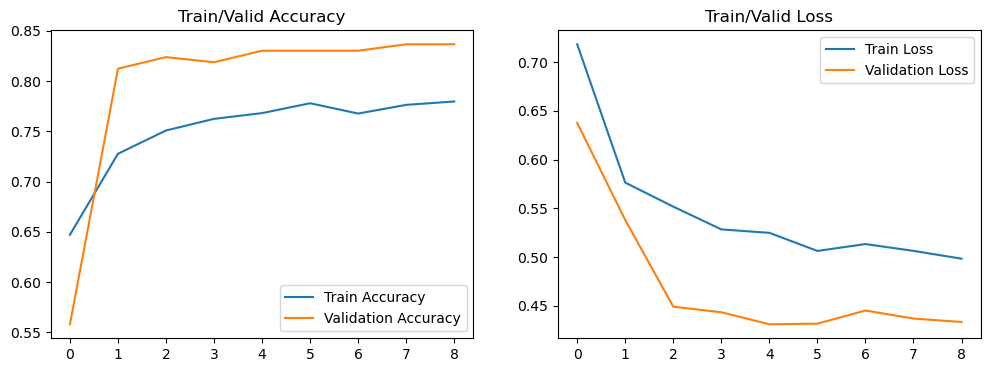

25/25 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       435
           1       0.88      0.74      0.80       348

    accuracy                           0.84       783
   macro avg       0.84      0.83      0.83       783
weighted avg       0.84      0.84      0.83       783



In [28]:
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

history = fit_model(X_train, y_train, X_val, y_val, epochs, callbacks)
history_df = pd.DataFrame(history.history)
history_df.index += 1
print(history_df)
plot_history(history)
get_report(model.predict(X_val, verbose=1), y_val)

We apply ensemble technique for cross-validaton. The 4 model with 4 different train/valid data fit and predict the test data. The point is each model trained on different dataset. And then combine those prediction by column wise averaging to get the final scores. 

Why would we need such a multiple predicitons? Is it good enough just by training whole data in one mode. We do that all for improving model's generality. One model could have better to predict non disaster tweets, while another are more good at disaster one. We make sure those generality due to our no duplicated train/validatoin set.

In [30]:
preds = []
for _ in range(4):
    # Prepare dataset
    X_train, X_val, y_train, y_val = train_test_nodupl_split(df_train, "input", val_prop=0.1, random_state=np.random.randint(1, 10^4))
    # Get the model
    model = get_model(encoder)
    model.compile(optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=base_lr, amsgrad=True), 
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.04), metrics=["accuracy"])
    # Training
    fit_model(X_train, y_train, X_val, y_val, epochs, callbacks)
    # Predicting
    pred = model.predict(df_test["input"], verbose=1)[:, 0]
    preds.append(pred)

102/102 [==============================] - 2s 11ms/step


We prepare our final submision file using predictions. The predictions is [0, 1] probabilities so we indicate 1 if it is above 0.5, otherwise 0.

In [31]:
sample_df = pd.read_csv(path/"sample_submission.csv", low_memory=True)
sample_df.target = (np.mean(preds, axis=0) > 0.5).astype(int)
sample_df.to_csv("submission.csv", index=False)
sample_df.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


## Discussion

The final score is `0.80876` from this submission. What we learning in this projects are as follows.

The thing that worked in this dataset and model:

* transfer learning, using universal sentence encoder
* cross-validation, hyper parameter tuning
* Prepare dataset so that duplicate text data doesn't exits in both train/valid set
* Add GRU RNN layers, instead of others like LSTM

The thing that did not work:

* Add local text into predictors
* Prepare randomized train/valid set
* Poor performance on less target, disaster tweets.

The future feature that might help:

* Data augmentation to less data, disaster tweets.
* Fine tuning to embedding layers(We tried but worsen performance, so there might be some ways to do it properly)
* Try other preprocessing text before feeding them to embedding(Although official docs say no need preprocessing, converting text to lowercanse improved a bit)

## Summary

We get final score `0.80876` for this competition. Our model is text binary classifier based on universal sentence encoder. The pretrained model are freezed since it is feature extractor. On top that embeded layers by encoder, we add GRU RNN layers and dense layers. We prepare our train/valid dataset without data leakage, that could improve the out model's performance a lot.

## References

* This notebook's github repo: https://github.com/Akitsuyoshi/intro_dl_week4
* NLP intro guide in kaggle: https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners
* Tutorial for transfer learning in Keras: https://amitness.com/2020/02/tensorflow-hub-for-transfer-learning/
* Official docs of universal-sentence-encoder: https://tfhub.dev/google/universal-sentence-encoder/4
* RNN model's implementation example for NLP: https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle/notebook
* Preprocess concept when using transfer learning as embedding layer: https://www.kaggle.com/code/christofhenkel/how-to-preprocessing-when-using-embeddings/notebook
* Tokenizer for sentence encoder: https://github.com/tensorflow/hub/issues/662
* CNN for image task: https://www.kaggle.com/code/akitsuyoshi/cnn-using-transfer-learning-in-keras